An introduction for using scikit learn pipeline and plot metrics for creating the best model which is tuned hyper parameters. 

Topic

* Cross Validation
* Learning Curve
* Validation Curve
* Grid Search

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [5]:
df = pd.read_csv('./voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
print("Total number of samples: {}".format(df.shape[0]))
print("Number of male: {}".format(df[df.label == 'male'].shape[0]))
print("Number of female: {}".format(df[df.label == 'female'].shape[0]))

Total number of samples: 3168
Number of male: 1584
Number of female: 1584


The target label of this classification is in "label" column and others are features.
These two categories ("male", "female") are just half and half. It seems no skew in this data set.
First we confirm to there is any missing values in this data sets. This is a common case a dataset in real world has missing values.

In [7]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

Okay we confirm there is not any missing values in any columns. Before creating learning pipeline it is not a bad idea to visualize overview and the relationship with each features. 


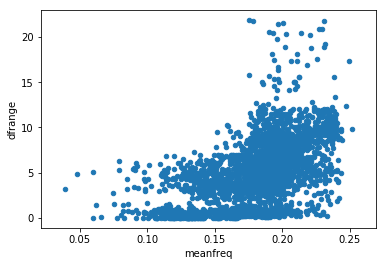

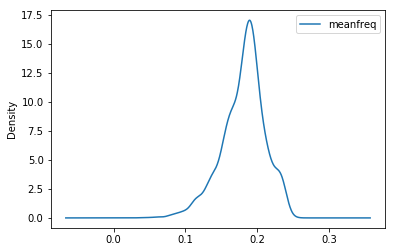

In [8]:
import warnings
warnings.filterwarnings("ignore")
import seaborn
df.head()
df.plot(kind='scatter', x='meanfreq', y='dfrange')
df.plot(kind='kde', y='meanfreq')
#seaborn.pairplot(df['meanfreq', 'sd', 'skew'], hue='label', size=2)

You can also do this easily with seaborn for visializing multiple feature relations.

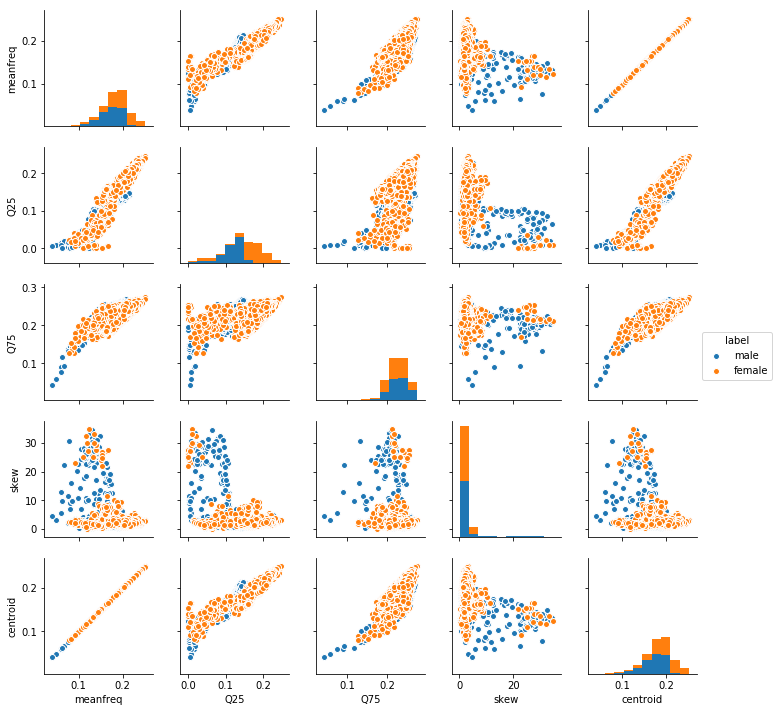

In [9]:
seaborn.pairplot(df[['meanfreq', 'Q25', 'Q75', 'skew', 'centroid', 'label']], 
                 hue='label', size=2)

These information sometimes can be useful to select features to be used for training model.
So now is the time to create training logic. Data set first should be separated with training data and test data for evaluating trained model.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

# Encode label category
# male -> 1
# female -> 0

gender_encoder = LabelEncoder()
y = gender_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Since scikit-learn provide Pipeline API which enables us to create preprocessing and machine learning model at once. 

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pipe_svc = Pipeline([('std_scl', StandardScaler()), 
                    ('pca', PCA(n_components=10)),
                    ('svc', SVC(random_state=1))])

pipe_svc.fit(X_train, y_train)

print('Test Accuracy: %.3f' % pipe_svc.score(X_test, y_test))

Test Accuracy: 0.976


At first grance we already gained pretty good accuracy which is over 97%.
But we might have a room for improvements. Now we evaluate this model from various type of metrics.

# Cross Validation

cross validation can provide more general metric of this model and it can enables us to reduce variance of the model.

Cross validation scores: [0.99215686 0.96850394 0.98031496 0.96442688 0.98023715 0.96837945
 0.98814229 0.99209486 0.98418972 0.97628458]


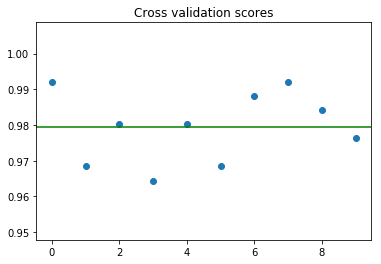

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_svc,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)

print('Cross validation scores: %s' % scores)

import matplotlib.pyplot as plt
plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

# Learning Curve

Learning curve enables us decide a model is over fitting to given training data and training under appropriate bias and variance balance. Now we try to plot learning curve of this model.

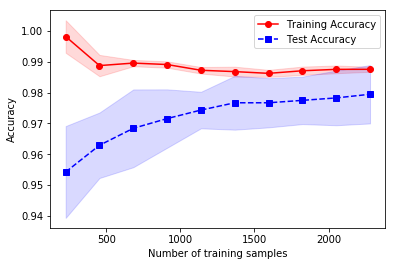

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10)

# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)

# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Although the variance of score against test data is somewhat higher, we cannot see the trend of over fitting  notably because test scores also improved along with training samples.

In addition, we can validation score along with a parameter. So next we try to plot validation curve.

# Validation Curve

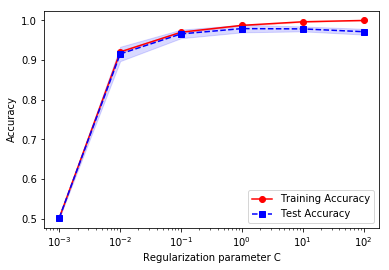

In [14]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_svc,
                                             X=X_train,
                                             y=y_train,
                                             param_name='svc__C',
                                             param_range=param_range,
                                             cv=10)

# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)

# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracies 
plt.plot(param_range, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(param_range, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

So we can estimate the best value of C can be 1 if C is over 1 test accuracy is decreasing.
It can cause overfitting of this model.

So how can we decide the best hyper parameter of this model without checking learning_curve and validation curve one by one? Grid search can be an option to do this.

# Grid Search

Grid search enables us to search all parameter combination of give hyper parameter space and evaluate models. After grid search you can obtain the best hyper parameter set.

In [16]:
from sklearn.model_selection import GridSearchCV

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
              {'svc__C': param_range, 'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)

# Training and searching hyper parameter space and evaluating model
# by using cross validation logic folded into 10
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9794790844514601
{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


Last but not least, you can check test accuracy with the best model again.

In [ ]:
best_model = gs.best_estimator_
best_model.fit(X_train, y_train)
print('Test Accuracy: %.3f' % best_model.score(X_test, y_test))

# Recap

I introduced how to create hyper parameter tuned model with checking necessary metrics 
such as learning curve and validation curve.

Although we cannot see any improvement by using grid search here 
(because the default parameter often provides good performance), I hope this is a good material how to use scikit learn pipeline and plot metrics. 